### need to check issues on no data defaulting into bare areas - problems identified in tassie
examples are hobart 2010 and 2015 or recent september tests on AWS

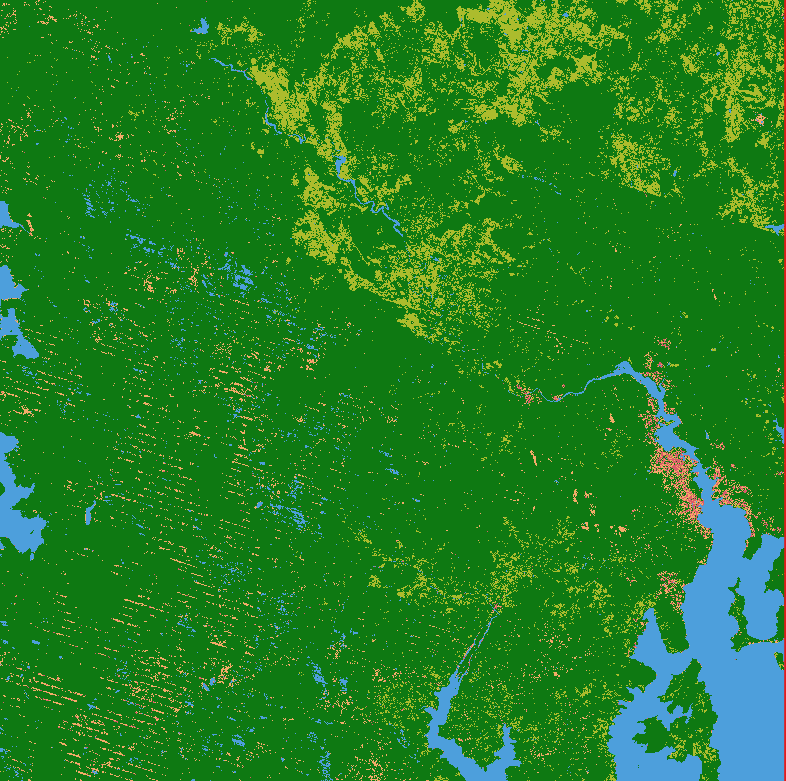

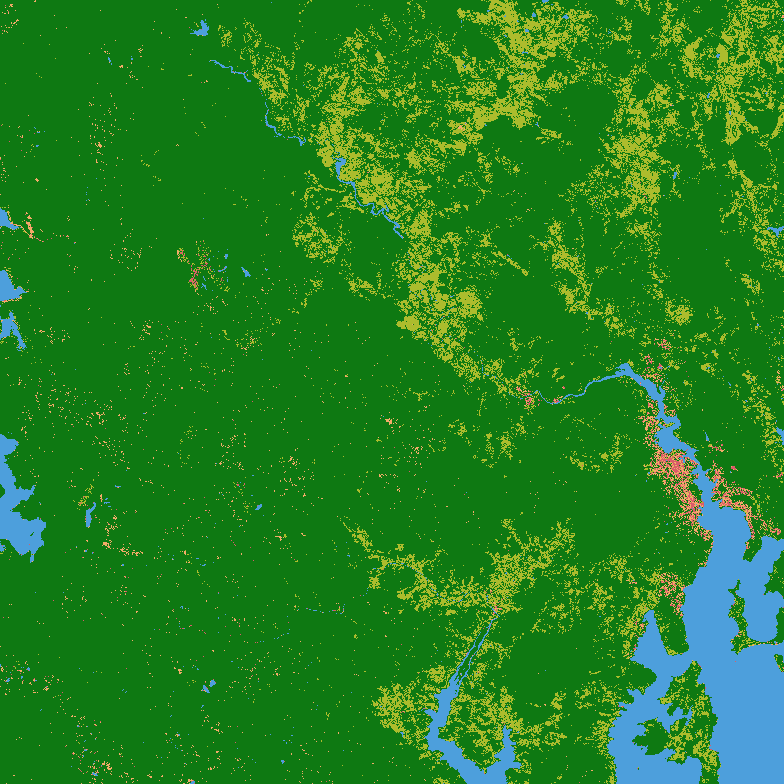

In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

dc = datacube.Datacube()

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'

sys.path.append("/home/jovyan/livingearth_lccs")

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(str(service)+"livingearth_lccs")
from le_lccs.le_ingest import gridded_ingest

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [3]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
yaml_sites_file = ("/home/jovyan/dev/dea-notebooks/Gabrielle_dev/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Hobart"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-100, 100)
time = ("2010-01-01", "2010-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

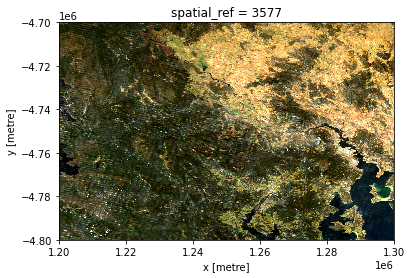

In [4]:
# Load Landsat
geomedian = dc.load(product="ls7_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [5]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file('chris_yaml.yaml')

In [6]:
# load fc wofs mask (already masked out by water flag from wofs as nan values in vp)
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

In [7]:
data = ls_fc_wofs_masked

def consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

def consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of non veg (0) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 0's to be classified as non veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is non veg (0)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive non veg classifications (hence label == 0)
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 0]

            # Inversed values from consecutive_count_veg to make non veg
            if not counts:
                consecutive_numpy[y,x] = 1
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 0
            else:
                consecutive_numpy[y,x] = 1

    return consecutive_numpy

data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
# this artificial inflation on BS ensures water areas are classified as non-veg
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# Don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_month['NPV'] > data_month['BS']
NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

##### veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For veg - run function to get array of with 1 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_veg = consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_veg = xr.DataArray(consecutive_numpy_veg, coords=tv_reduce.coords, dims=tv_reduce.dims)  

##### non veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2        

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values        

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For non veg - run function to get array of with 0 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_nonveg = consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_nonveg = xr.DataArray(consecutive_numpy_nonveg, coords=tv_reduce.coords, dims=tv_reduce.dims)

## Combine veg and non veg masks (to ensure no data is correctly identified)
tv_combine = tv_summary_veg + tv_summary_nonveg

# Make values of 2 == 1 (end result in binary veg mask)
tv_combine_drop = np.where(tv_combine == 2, 1, tv_combine)

# Create new data array with sampe dimensions as original
tv_summary = xr.DataArray(tv_combine_drop, coords=tv_reduce.coords, dims=tv_reduce.dims)

# making wofs mask product
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_mask = ((wofs_ann["frequency"] >= 0.2)).squeeze().drop('time')

# making saltpan_mask and mudflat_mask
# load best pixel geomedian
product = catalog['best_pixel_gm']
best_pixel_gm = product.load(dc, **query)
# saltpan_mask
best_pixel_gm['saltpan_mask'] = ((best_pixel_gm['blue']*best_pixel_gm['red'])/best_pixel_gm['green']).drop('time').squeeze()
saltpan_mask = best_pixel_gm.saltpan_mask
saltpan_mask.values = np.where(saltpan_mask < 1500, 1, 0)
# mudflat_mask
best_pixel_gm['mudflat_mask'] = ((best_pixel_gm['blue']*best_pixel_gm['red'])/best_pixel_gm['green']).drop('time').squeeze()
mudflat_mask = best_pixel_gm.mudflat_mask
mudflat_mask.values = np.where(mudflat_mask > 1000, 1, 0)

# ingest DEM for combination with mudflat_mask
var_file = "/home/jovyan/development/livingearth_australia/masks/lte6_0_1bit.tif"
var_name = "lessthan6m"

import_obj = gridded_ingest.LEIngestGDAL(extent_x[0], extent_x[1], extent_y[0], extent_y[1],res[1],res[0], crs)
DEM = import_obj.read_to_xarray(var_file, var_name)
DEM_mask = DEM.lessthan6m

# making mangroves product
mangrove = dc.load(product="mangrove_cover", measurements=["extent"], **query)
mangrove_mask = (mangrove["extent"] == 1).squeeze().drop('time')

# current best level 1 product
vegetat_veg_cat_current = ((tv_summary) * (1-(wofs_mask)) * (saltpan_mask) * (1-(mudflat_mask * DEM_mask)) == 1) | (mangrove_mask ==1)

### this is the statement we want, just need to add in OR mangrove, but can't seem to get it to work
# vegetat_veg_cat_current = ((tv_summary) * (1-(wofs_mask)) * (saltpan_mask) * (1-(mudflat_mask * DEM_mask)))


KeyError: 'extent'

In [ ]:
wofs_mask_inverted = (1-(wofs_mask))
mudflat_DEM_mask = (1-(mudflat_mask * DEM_mask))
mangrove_binary_mask = (mangrove_mask == 1)

plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(2,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
vegetat_veg_cat_current.plot.imshow()
ax2.set_title('vegetat_veg_cat_current')

ax3=plt.subplot(gs[0,2])
tv_summary.plot.imshow()
ax3.set_title('tv_summary')

ax4=plt.subplot(gs[1,0])
wofs_mask_inverted.plot.imshow()
ax4.set_title('wofs_mask_inverted')

ax5=plt.subplot(gs[1,1])
saltpan_mask.plot.imshow()
ax5.set_title('saltpan_mask')

ax6=plt.subplot(gs[1,2])
mudflat_DEM_mask.plot.imshow()
ax6.set_title('mudflat_DEM_mask')

ax7=plt.subplot(gs[1,3])
mangrove_binary_mask.plot.imshow()
ax7.set_title('mangrove_binary_mask')

plt.tight_layout()
plt.show()

In [ ]:
# current best level 1 product
vegetat_veg_cat_current = ((tv_summary) * (1-(wofs_mask)) * (saltpan_mask) * (1-(mudflat_mask * DEM_mask)) == 1) | (mangrove_mask ==1)
vegetat_veg_cat_current.plot()

In [ ]:
# current best level 1 product
vegetat_veg_cat_current = (((tv_summary) * (1-(wofs_mask)) * (saltpan_mask) * (1-(mudflat_mask * DEM_mask)) == 1) + (mangrove_mask ==1)) >=1
vegetat_veg_cat_current.plot()

In [ ]:
# fc_veg
np.unique(tv_summary)

In [ ]:
# wofs_mask
np.unique(wofs_mask_inverted)

In [ ]:
# saltpan_mask
np.unique(saltpan_mask)

In [ ]:
# mudflat_mask
np.unique(mudflat_DEM_mask)

In [ ]:
# Current outcome
np.unique(vegetat_veg_cat_current)

In [ ]:
mangrove_binary_mask

In [ ]:
mangrove_binary_mask1 = mangrove_binary_mask.astype('float64')
mangrove_binary_mask1

In [ ]:
saltpan_mask